In [2]:
import pandas as pd
import numpy as np

In [41]:
delivery_train = pd.read_csv('delivery_time_train_data.csv')
delivery_test = pd.read_csv('delivery_time_test_data.csv')
student_train = pd.read_csv('student_train_data.csv')
student_test = pd.read_csv('student_test_data.csv')

In [4]:
delivery_train.head()

,Miles,Deliveries,Time
0,100,4,9.3
1,50,3,4.8
2,100,4,8.9
3,100,2,6.5
4,50,2,4.2


In [5]:
delivery_test.head()

,Miles,Deliveries,Time
0,50,3,4.6
1,65,2,5.5
2,80,1,6.3
3,70,1,6.2
4,70,5,8.5


In [6]:
student_train.head()

,GPA,Age,Dropped
0,3.78,21,0
1,2.38,27,0
2,3.05,21,1
3,2.19,28,1
4,3.22,23,0


In [7]:
student_test.head()

,GPA,Age,Dropped
0,2.49,26,1
1,2.67,29,0
2,2.86,29,1
3,2.21,26,0
4,2.91,20,1


In [233]:
X_delivery_train = delivery_train[['Miles','Deliveries']]
y_delivery_train = delivery_train['Time']

X_delivery_test = delivery_test[['Miles','Deliveries']]
y_delivery_test = delivery_test['Time']

X_student_train = student_train[['GPA','Age']]
y_student_train = student_train['Dropped']

X_student_test = student_test[['GPA','Age']]
y_student_test = student_test['Dropped']

In [238]:
print(X_delivery_train.shape)
print(y_delivery_train.shape)
print(X_delivery_test.shape)
print(y_delivery_test.shape)
print(X_student_train.shape)
print(y_student_train.shape)
print(X_student_test.shape)
print(y_student_test.shape)

(199, 2)
(199,)
(101, 2)
(101,)
(400, 2)
(400,)
(100, 2)
(100,)


In [53]:
def delivery_dist(a,b):
    return np.sqrt( (b[1]-a[1])**2 + (b[0]-a[0])**2 )

def knn_predict(X_train,y_train,X_test, k=5):
    y_pred = list()
    for i in range(len(X_test)):
        dist_lst = list()
        for j in range(len(y_train)):
            dist_lst.append(delivery_dist(X_test.iloc[i],X_train.iloc[j]))
        temp_df = pd.DataFrame({'Train':y_train,'Dist':dist_lst})
        temp_df.sort_values(by='Dist',inplace=True)
        y_pred.append(np.mean(temp_df['Train'][:k]))
    return y_pred

In [56]:
y_delivery_test_pred = knn_predict(X_delivery_train,y_delivery_train,X_delivery_test)

In [57]:
def mse(actual,pred):
    tot_err = 0
    n = len(actual)
    for i in range(n):
        tot_err += (actual[i] - pred[i])**2
    return tot_err/n

In [58]:
mse(y_delivery_test,y_delivery_test_pred)

1.0977544554455447

In [59]:
y_delivery_train_pred = knn_predict(X_delivery_train,y_delivery_train,X_delivery_train)

In [60]:
mse(y_delivery_train,y_delivery_train_pred)

0.5889105527638189

In [65]:
k_list = list(range(1,51))
acc_lst = list()
for k in k_list:
    pred_vec = knn_predict(X_delivery_train,y_delivery_train,X_delivery_test,k)
    acc_lst.append(mse(y_delivery_test,pred_vec))

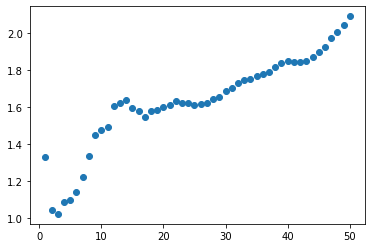

In [67]:
import matplotlib.pyplot as plt
plt.scatter(k_list,acc_lst)

In [70]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
knr = KNeighborsRegressor(n_neighbors=5)
knr.fit(X_delivery_train,y_delivery_train)
delivery_pred = knr.predict(X_delivery_test)
mean_squared_error(y_delivery_test,delivery_pred)

1.1209346534653466

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline( [('scaler',StandardScaler()), ('knr',KNeighborsRegressor(n_neighbors=5))])
pipe.fit(X_delivery_train,y_delivery_train)
mean_squared_error(y_delivery_test,pipe.predict(X_delivery_test))

1.0048316831683173

In [75]:
from sklearn.ensemble import RandomForestRegressor
pipe2 = Pipeline([('scaler',StandardScaler()),('rand_forest',RandomForestRegressor(n_estimators=50))])
pipe2.fit(X_delivery_train,y_delivery_train)
mean_squared_error(y_delivery_test,pipe2.predict(X_delivery_test))

0.9592297465366237

In [239]:
sc = StandardScaler()
X_student_train_std = sc.fit_transform(X_student_train)
X_student_test_std = sc.transform(X_student_test)

In [240]:
def knn_predict2(X_train,y_train,X_test, k=5):
    y_pred = list()
    for i in range(len(X_test)):
        dist_lst = list()
        for j in range(len(y_train)):
            dist_lst.append(delivery_dist(X_test[i],X_train[j]))
        temp_df = pd.DataFrame({'Labels':y_train,'Dist':dist_lst})
        temp_df.sort_values(by='Dist',inplace=True)
        y_pred.append(max_index(temp_df.iloc[:20]))
    return y_pred

In [241]:
def max_index(in_df):
    dct = {}
    for val in in_df['Labels'].unique():
        dct[val] = 0
    for i in range(len(in_df)):
        dct[in_df['Labels'].iloc[i]] += 1 
    max_count = 0
    max_ind = 0
    for key in dct.keys():
        if dct[key] > max_count:
            max_count = dct[key]
            max_ind = key
    return(max_ind)


In [243]:
y_student_test_pred = knn_predict2(X_student_train_std,y_student_train,X_student_test_std)

In [261]:
def overall_accuracy(true,pred):
    return list(y_student_test_pred == y_student_test).count(True)/len(true)

In [262]:
overall_accuracy(y_student_test,y_student_test_pred)

0.74

In [267]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':[1,5,10,20,30,40,50]}
knr_gs = GridSearchCV(KNeighborsClassifier(),param_grid)
knr_gs.fit(X_student_train_std,y_student_train)
knr_gs.best_params_

{'n_neighbors': 40}

In [269]:
knr_opt = KNeighborsClassifier(n_neighbors = 40)
knr_opt.fit(X_student_train_std,y_student_train)
knr_y_pred = knr_opt.predict(X_student_test_std)
knr_opt.score(X_student_test_std,y_student_test)

0.73

In [275]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=50)
forest.fit(X_student_train_std,y_student_train)
forest.score(X_student_test_std,y_student_test)

0.62

In [276]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=50)
forest.fit(X_student_train,y_student_train)
forest.score(X_student_test,y_student_test)

0.64

In [350]:
toxicity_data = pd.read_csv('qsar_aquatic_toxicity.csv',delimiter=';',header=None)

In [351]:
toxicity_data

,0,1,2,3,4,5,6,7,8
0,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995


In [352]:
X = toxicity_data.iloc[:,:6]
y = toxicity_data.iloc[:,-1]

In [353]:
sc_tox = StandardScaler()
sc_tox.fit_transform(X)

array([[-1.03749461, -0.86439755, -0.57986562,  0.06062937, -1.56406229,
        -0.940384  ],
       [-1.03749461, -0.86439755, -0.57986562,  0.18647687, -1.3468483 ,
        -1.02716647],
       [-0.8399395 , -0.70288011, -0.57986562,  2.00293318,  0.54019817,
        -1.3891733 ],
       ...,
       [-1.03749461, -0.86439755, -0.57986562,  1.63860755,  0.76358301,
        -0.77921658],
       [-0.75625147, -0.72480243, -0.57986562,  0.31347366,  0.15020034,
        -0.54366419],
       [-1.03749461, -0.86439755, -0.57986562, -0.03361259, -0.85441433,
        -0.32050929]])

In [354]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [355]:
knr_tox = KNeighborsRegressor(n_neighbors = 5)
knr_tox.fit(X_train,y_train)

KNeighborsRegressor()

In [361]:
tox_params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,15,20,30,40,50]}
tox_gs = GridSearchCV(KNeighborsRegressor(), tox_params, cv=8)
tox_gs.fit(X_train,y_train)

GridSearchCV(cv=8, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20,
                                         30, 40, 50]})

In [362]:
tox_gs.best_params_

{'n_neighbors': 3}

In [363]:
knr_tox_opt = KNeighborsRegressor(n_neighbors=3)
knr_tox_opt.fit(X_train,y_train)
knr_tox_opt.score(X_test,y_test)

0.4169540971570882

In [364]:
knr_tox_opt.score(X_train,y_train)

0.6736241102687792